In [1]:
library(dplyr)
library(readr)
library(ggplot2)
library(geoR)
library(glinternet)
library(sn)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

--------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.7-5.2.1 (built on 2016-05-02) is now loaded
--------------------------------------------------------------

Loaded glinternet 1.0.10

Loading required package: stats4

Attaching package: ‘sn’

The following object is masked from ‘package:stats’:

    sd



# Preparing input data

In [2]:
inforce = read_csv('../data/raw/inforce.csv');
greek= read_csv('../data/raw/Greek.csv');
representative_index = read_csv('../data/raw/hkmeans2.csv', col_names = F);

# merging
data = merge(inforce, greek, by = 'recordID');

# creating and treating variables 
data = data %>% mutate(
    age = (currentDate-birthDate)/365,  
    ttm = (matDate - currentDate)/365,
    gender=as.numeric(as.factor(gender))-1, 
    productType=as.numeric(as.factor(productType))-1,
    fmv = fmv/1000000);

# names of the columns to fit the model

x_columns = c(
    # explanatory variables
    "gbAmt", 
    "gmwbBalance", 
    "withdrawal", 
    paste0("FundValue", c(1:10)), 
    "age", 
    "ttm", 
    "gender", 
    "productType")

columns = c("recordID", x_columns, "fmv")

data = select(data, columns)
train = data %>% filter(recordID %in% representative_index$X2)

numLevels = c(rep(1, length(columns)-4), 2, 19)


Parsed with column specification:
cols(
  .default = col_double(),
  gender = col_character(),
  productType = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  recordID = col_double(),
  fmv = col_double(),
  Delta1 = col_double(),
  Delta2 = col_double(),
  Delta3 = col_double(),
  Delta4 = col_double(),
  Delta5 = col_double(),
  Rho1y = col_double(),
  Rho2y = col_double(),
  Rho3y = col_double(),
  Rho4y = col_double(),
  Rho5y = col_double(),
  Rho7y = col_double(),
  Rho10y = col_double(),
  Rho30y = col_double()
)
Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double()
)


In [3]:
columns

[1] "recordID"    "gbAmt"       "gmwbBalance" "withdrawal"  "FundValue1" 
 [6] "FundValue2"  "FundValue3"  "FundValue4"  "FundValue5"  "FundValue6" 
[11] "FundValue7"  "FundValue8"  "FundValue9"  "FundValue10" "age"        
[16] "ttm"         "gender"      "productType" "fmv"

In [4]:
head(train)

recordID,gbAmt,gmwbBalance,withdrawal,FundValue1,FundValue2,FundValue3,FundValue4,FundValue5,FundValue6,FundValue7,FundValue8,FundValue9,FundValue10,age,ttm,gender,productType,fmv
75,271411.3,0,0,28427.73,0.00,18431.446,12666.804,26286.41,29517.97,23141.99,19758.41,0.00,23420.26,46.69863,12.67945,0,0,0.047447117
101,398757.1,0,0,49665.40,49849.96,44726.658,33220.960,38142.56,49782.58,47192.76,40710.37,46292.79,42749.05,46.19726,23.26849,1,0,-0.010095459
320,125572.4,0,0,19404.08,18209.31,12461.802,9826.634,12416.88,18957.09,15603.46,13925.20,0.00,14178.30,53.44932,22.26849,1,0,-0.003151129
490,362221.6,0,0,35227.25,34350.37,20240.242,14037.126,28732.72,35259.49,26974.79,23104.23,24125.77,26493.22,52.86849,10.00822,0,0,0.063213256
504,371946.0,0,0,35957.04,32952.27,18854.475,20879.922,31259.08,34936.23,26242.14,28193.52,22567.73,28231.69,38.27671,19.09589,1,0,0.034840260
593,180797.7,0,0,17180.81,15582.34,9561.559,9283.301,15230.05,16639.26,12926.14,12999.95,11216.82,13503.40,37.77260,10.26027,0,0,0.033622566


In [5]:
head(data)

recordID,gbAmt,gmwbBalance,withdrawal,FundValue1,FundValue2,FundValue3,FundValue4,FundValue5,FundValue6,FundValue7,FundValue8,FundValue9,FundValue10,age,ttm,gender,productType,fmv
1,87657.37,0,0,0.00,0.00,0.00,45008.86,0.00,0.00,0.00,0.00,0.00,0.00,47.36164,19.26575,0,0,0.016763295
2,161534.10,0,0,25681.18,0.00,23096.98,16719.40,19297.09,25791.35,24386.58,0.00,23949.69,21906.86,57.78630,18.18082,1,0,-0.004803217
3,407190.05,0,0,0.00,0.00,0.00,0.00,389147.88,0.00,0.00,0.00,0.00,0.00,53.12055,18.18082,1,0,-0.036038487
4,307425.14,0,0,0.00,0.00,52957.63,0.00,85110.56,0.00,0.00,0.00,62465.01,0.00,42.86301,14.68219,1,0,0.045419127
5,356480.86,0,0,0.00,27505.37,12784.85,14425.32,31306.97,24655.37,17119.72,18851.82,16424.64,21829.42,62.70959,11.17534,0,0,0.097013360
6,275079.73,0,0,34449.27,33844.28,31926.71,0.00,29442.19,34228.91,33179.90,30762.85,32515.50,31363.51,52.70137,19.92877,1,0,-0.001736302


## Fitting the metamodel

### Estimating parameters for Box-Cox transform

In [6]:
bx_fit = boxcoxfit(train$fmv, lambda2 = T)
print(bx_fit)

Fitted parameters:
     lambda     lambda2        beta     sigmasq 
-0.15209966  0.03088893 -3.15189069  1.85096290 

Convergence code returned by optim: 0


## Estimating lambda1

In [7]:
min(data$fmv)

[1] -0.06993825

In [8]:
shift = 0.1

In [9]:
bx_fit = boxcoxfit(train$fmv + shift)
lambda1 = bx_fit$lambda[1]
#lambda2 = bx_fit$lambda[2]
lambda2 = shift
print(bx_fit)
print(c(lambda1, lambda2))

Fitted parameters:
    lambda       beta    sigmasq 
-0.9670159 -5.5449782  7.1471586 

Convergence code returned by optim: 0
[1] -0.9670159  0.1000000


## Transforming FMVs

In [10]:
bc.transform <- function(v, l1, l2) {
    return (((v + l2)^l1 - 1) / l1)
}

## Overlapped group lasso

In [11]:
head(select(train, x_columns))

gbAmt,gmwbBalance,withdrawal,FundValue1,FundValue2,FundValue3,FundValue4,FundValue5,FundValue6,FundValue7,FundValue8,FundValue9,FundValue10,age,ttm,gender,productType
271411.3,0,0,28427.73,0.00,18431.446,12666.804,26286.41,29517.97,23141.99,19758.41,0.00,23420.26,46.69863,12.67945,0,0
398757.1,0,0,49665.40,49849.96,44726.658,33220.960,38142.56,49782.58,47192.76,40710.37,46292.79,42749.05,46.19726,23.26849,1,0
125572.4,0,0,19404.08,18209.31,12461.802,9826.634,12416.88,18957.09,15603.46,13925.20,0.00,14178.30,53.44932,22.26849,1,0
362221.6,0,0,35227.25,34350.37,20240.242,14037.126,28732.72,35259.49,26974.79,23104.23,24125.77,26493.22,52.86849,10.00822,0,0
371946.0,0,0,35957.04,32952.27,18854.475,20879.922,31259.08,34936.23,26242.14,28193.52,22567.73,28231.69,38.27671,19.09589,1,0
180797.7,0,0,17180.81,15582.34,9561.559,9283.301,15230.05,16639.26,12926.14,12999.95,11216.82,13503.40,37.77260,10.26027,0,0


In [12]:
run<-function(data, x_columns, y_column, y_shift=NA, box.cox=FALSE) {
    
    X = select(data, x_columns)
    Y = data[[y_column]]
    
    if(!is.na(y_shift)) {
        Y = Y + y_shift
    }
    
    fit.bc = NA
    lambda1 = NA
    lambda2 = NA
    if(box.cox == TRUE) {
        fit.bc = boxcoxfit(Y)
        lambda1 = fit.bc$lambda[1]
        lambda2 = y_shift
        Y = bc.transform(Y, lambda1, lambda2)        
    }
    
    fit = glinternet.cv(X=X, Y=Y, numLevels,tol = 1e-10)
    
    residuals = Y - fit$fitted
    
    return(list(
        y_shift = y_shift,
        fit.bc = fit.bc,
        lambda1 = lambda1,
        lambda2 = lambda2,
        X = X,
        Y = Y,
        fit = fit,
        residuals = residuals
    ))
}

In [13]:
shift

[1] 0.1

In [14]:
result = run(train, x_columns, "fmv", 0, FALSE)

In [15]:
result.bc = run(train, x_columns, "fmv", shift, TRUE)

## Checking gaussianity of FMVs and residuals

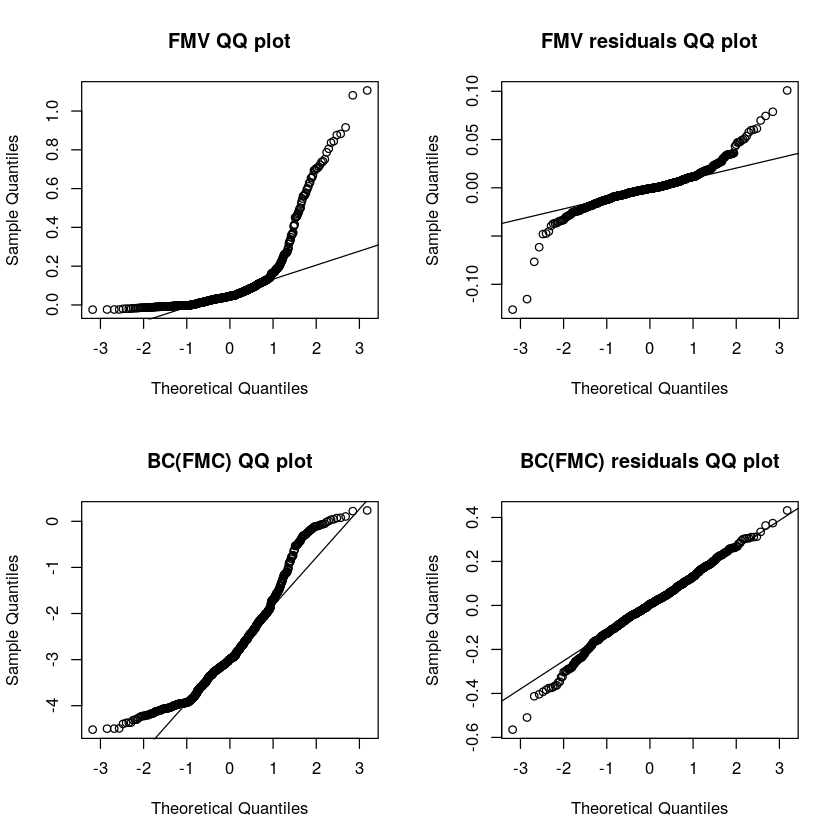

In [16]:
par(mfrow=c(2,2))
qqnorm(train$fmv, main="FMV QQ plot"); qqline(train$fmv)
qqnorm(result$residuals, main="FMV residuals QQ plot"); qqline(result$residuals)
qqnorm(result.bc$Y, main="BC(FMC) QQ plot"); qqline(result.bc$Y)
qqnorm(result.bc$residuals, main="BC(FMC) residuals QQ plot"); qqline(result.bc$residuals)

## Checking predictions on the training set

In [17]:
head(train[1,x_columns])

gbAmt,gmwbBalance,withdrawal,FundValue1,FundValue2,FundValue3,FundValue4,FundValue5,FundValue6,FundValue7,FundValue8,FundValue9,FundValue10,age,ttm,gender,productType
271411.3,0,0,28427.73,0,18431.45,12666.8,26286.41,29517.97,23141.99,19758.41,0,23420.26,46.69863,12.67945,0,0


In [18]:
fmv.pred = predict(result.bc$fit, train[x_columns])
results = data.frame(list(recordID=train$recordID, fmv=train$fmv, fmv.pred=fmv.pred))

In [19]:
head(results)

recordID,fmv,fmv.pred
75,0.047447117,-2.971994
101,-0.010095459,-4.090594
320,-0.003151129,-4.029143
490,0.063213256,-2.875065
504,0.034840260,-3.271453
593,0.033622566,-3.122921


In [20]:
sigma2 = var(result.bc$residuals)

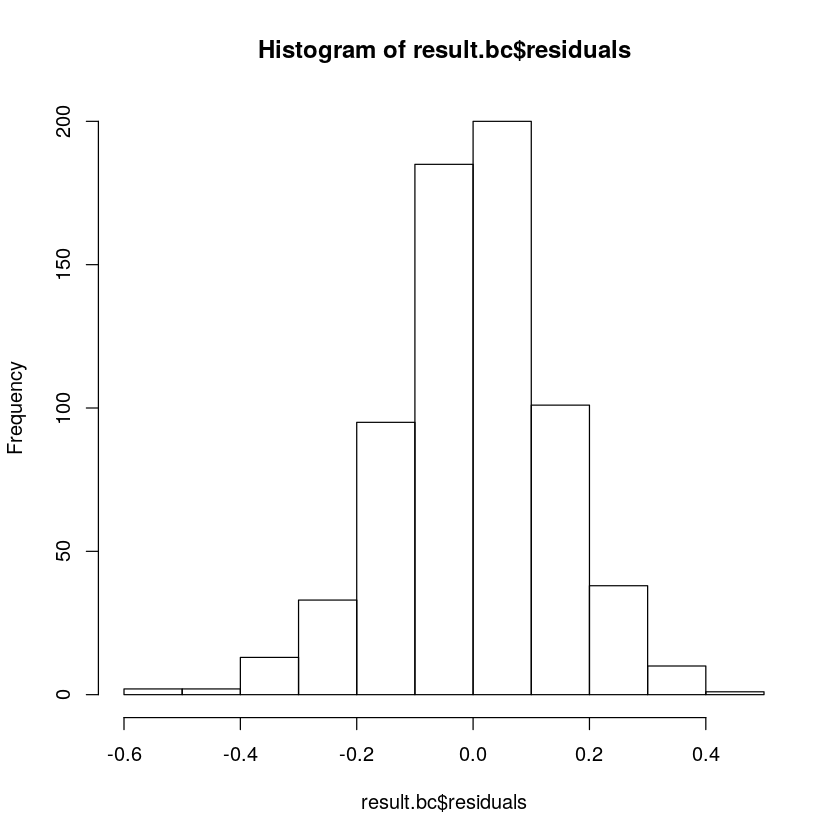

In [21]:
hist(result.bc$residuals)

In [22]:
sqrt(sigma2)

[1] 0.1393106

In [23]:
num = 1000000
eps = rnorm(num, mean=0, sd=sqrt(sigma2))

In [26]:
bc.inverse <- function(v, l1, l2) {
    return ((v * l1 + 1)^(1/l1) - l2)
}

In [27]:

bc.inverse.mc<-function(data, fit, num=1e6) {
    sigma = sqrt(var(fit$residuals))
    eps = rnorm(num, mean=0, sd=sigma)
    pred = predict(fit$fit, data)
    values = rep(NA, length(pred))
    for(i in 1:length(values))
    {
        values[i] = median(bc.inverse(pred[i] + eps, fit$lambda1, fit$lambda2))
    }
    return (values)                       
}


In [28]:
values = bc.inverse.mc(train[x_columns], result.bc)

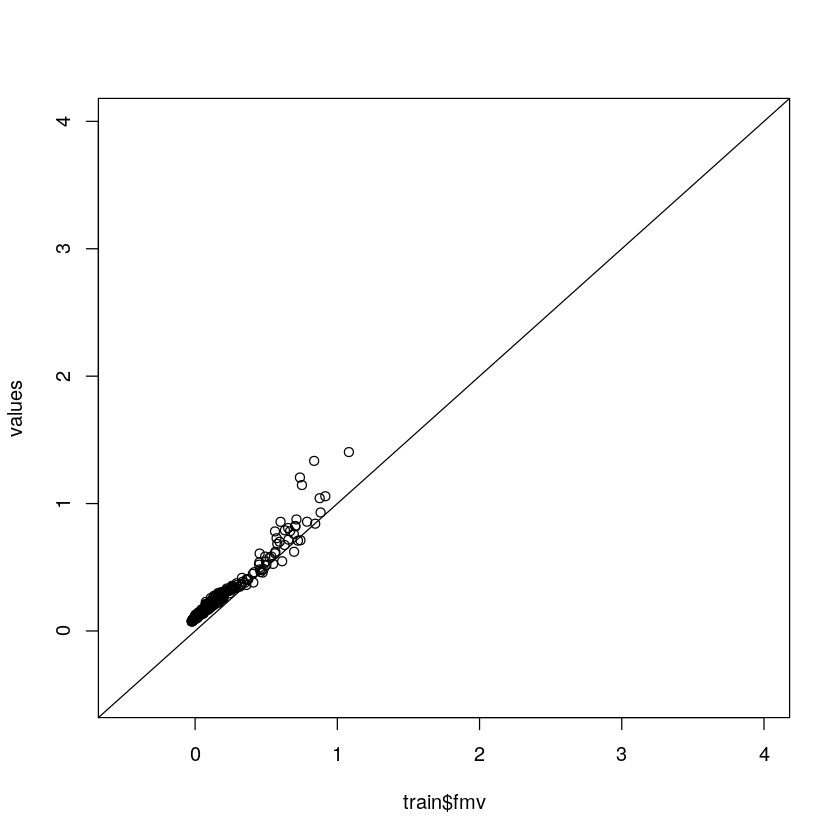

In [32]:
plot(train$fmv, values, xlim=c(-0.5, 4), ylim=c(-0.5, 4));abline(0,1)

In [33]:
ystar = results$fmv.pred[1] + eps

In [34]:
print(results$fmv.pred[1])

[1] -2.971994


In [35]:
result.bc$lambda1

[1] -0.9670159

In [36]:
result.bc$lambda2

[1] 0.1

In [37]:

yhat = (bc.inverse(ystar, result.bc$lambda1, result.bc$lambda2))


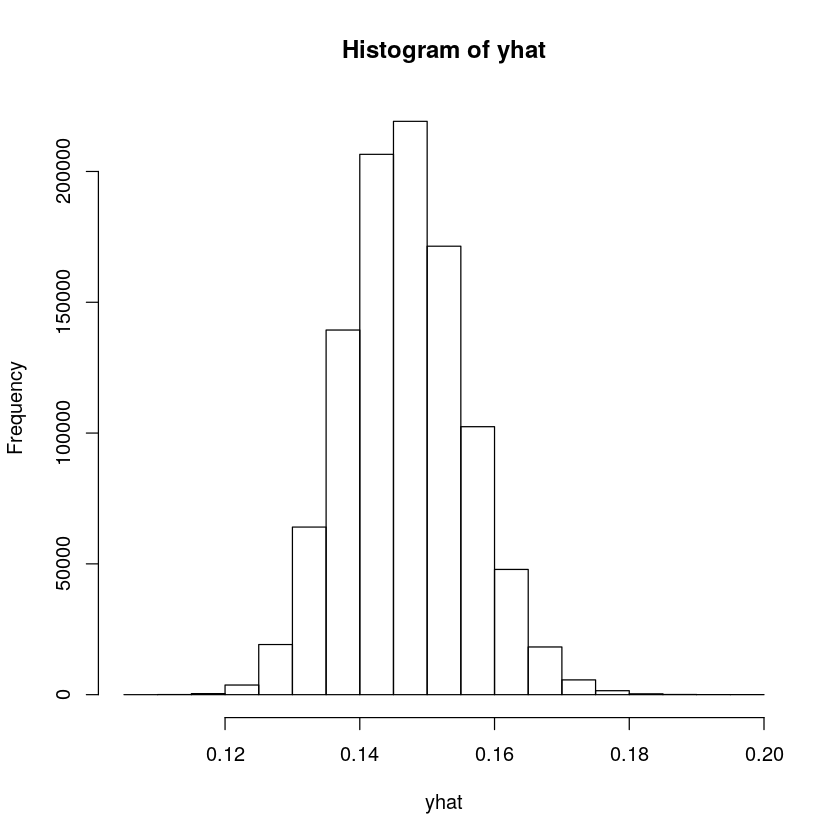

In [38]:
hist(yhat)

## Checking formula sensitivity to error

In [39]:
y = 10
l1 = -0.756290873
l2 = 100
ystar = bc.transform(y, l1, l2)
yhat = bc.inverse(ystar + 1e-4, l1, l2)
print(sprintf("%f %f %f %f", y, l1, l2, yhat))

[1] "10.000000 -0.756291 100.000000 10.386025"


## Checking predictions on the whole dataset

In [41]:
values = bc.inverse.mc(data[x_columns], result.bc, num=1e4)

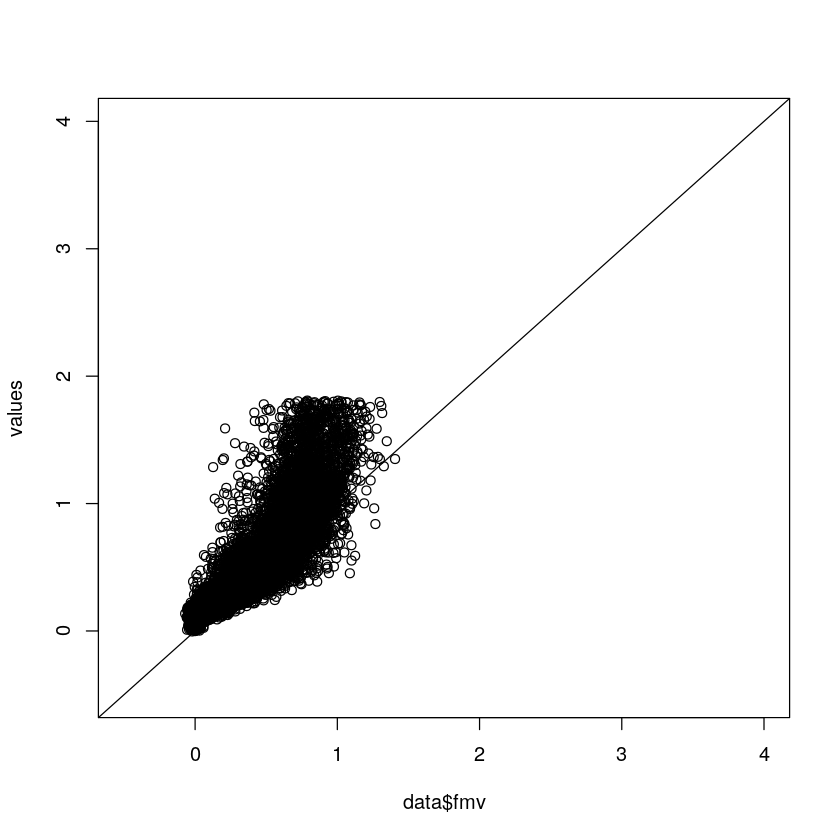

In [42]:
plot(data$fmv, values, xlim=c(-0.5, 4), ylim=c(-0.5, 4));abline(0,1)

In [43]:
temp = order(data$fmv)

In [44]:
head(temp)

[1]  33581 161751 167554 143945  65090 147260

In [59]:
representative_index$X2

[1]     75    101    320    490    504    593    958   1035   1352   1396
 [11]   1399   1477   1701   2075   2222   2226   2303   2790   2812   3666
 [21]   3736   4017   4201   4216   4573   4924   4946   5198   5596   6470
 [31]   6841   7047   8040   8136   9568   9705   9860  10757  10951  10986
 [41]  11237  11310  11692  11902  11976  12049  12155  12218  12499  12811
 [51]  13084  13544  13779  13877  14741  15025  15393  15415  16067  16204
 [61]  16932  17169  17179  17224  17282  18434  18872  18971  18979  19284
 [71]  19396  19465  19911  19962  19968  20022  20694  21719  22184  22711
 [81]  22767  22791  22926  23085  23233  23448  23582  23828  24019  24048
 [91]  24488  24492  24528  24638  24731  24880  25103  25318  25341  25641
[101]  26479  26710  27322  27633  27704  28065  28074  28274  29088  29233
[111]  29738  29806  30013  30021  30536  30611  30790  30904  31790  32767
[121]  32920  33034  33690  33984  34041  34090  34530  34564  34926  35437
[131]  36100  36138  36399  36514  36604  36866  36972  37027  37190  37445
[141]  37630  37742  37997  38521  38572  38654  38910  39930  40106  40111
[151]  40203  41085  41194  41305  41472  41708  41950  42103  42261  42740
[161]  42969  43066  43605  43723  43736  44266  44372  44684  44890  45138
[171]  45689  45886  46060  46297  46630  47044  47111  47136  47179  47728
[181]  48112  48290  48363  48710  48891  48916  49035  50177  50181  50492
[191]  50681  50719  51738  51905  51914  51978  51985  52183  52563  53372
[201]  53987  54215  54468  54487  54766  54884  55383  55629  56110  56157
[211]  56844  57409  57480  58213  58224  58557  58635  58848  59129  59278
[221]  59943  60000  60471  60804  60857  60926  60963  61458  61467  62287
[231]  62453  62454  62890  63273  63510  63722  64237  64288  65322  65379
[241]  65757  66345  66690  66900  67203  67779  68110  68157  68180  68806
[251]  68838  68982  69161  69254  69273  69727  70175  70897  71030  71154
[261]  71329  72639  73113  73187  73275  73916  74344  74438  74569  75051
[271]  75155  75496  75745  75995  76704  76901  77161  77256  77760  77761
[281]  77816  78161  78238  78545  78682  78721  79048  79117  79666  79714
[291]  80328  80721  80731  81113  81220  81221  81734  81787  81886  81953
[301]  82166  82275  82400  82561  83344  83612  83762  84171  84184  84329
[311]  84386  84764  86042  86126  86166  86189  86259  86575  86643  86861
[321]  89287  89462  89487  89841  89972  90349  90551  90570  90993  91025
[331]  91215  91821  91874  91889  92019  92147  92511  92975  93505  93641
[341]  93849  94057  94100  94463  95375  95394  95426  95582  95585  95703
[351]  96536  96886  96989  97009  97455  98050  98365  98516  99698  99932
[361] 100270 100348 100562 100791 101012 101730 101774 101988 102104 103090
[371] 103263 103448 103594 103657 103844 104030 104169 104640 104799 104881
[381] 105318 105324 105407 105761 105991 106382 107094 107121 107268 107462
[391] 107618 107755 108060 108988 109053 109186 109417 109436 110166 110320
[401] 110436 110840 111090 111330 111336 111437 111587 111649 112381 113515
[411] 113606 114150 114190 114599 114758 114816 114968 115188 115405 115943
[421] 116233 116282 116536 117061 118018 118120 118148 119294 119367 119768
[431] 119834 119978 120094 120441 120473 120557 120733 120921 121072 121250
[441] 121387 121541 121971 122614 122978 123224 123234 123673 123946 124269
[451] 124286 124457 124461 124700 125359 125423 125522 125888 125947 126223
[461] 126733 126798 127389 127503 127660 128314 128899 128989 129634 130019
[471] 130344 130629 130723 130841 131002 131399 131429 131905 132281 132368
[481] 132387 132534 133656 133799 134239 134466 135271 135348 135373 135385
[491] 135572 135655 135677 135913 135959 135973 136605 136915 137804 138242
[501] 138498 138743 138961 139241 139919 140271 140487 140790 140924 141278
[511] 141512 142346 142460 143351 143395 143942 144010 144229 144454 144531
[521] 144669 145019 145091 145111 145553 145902 14

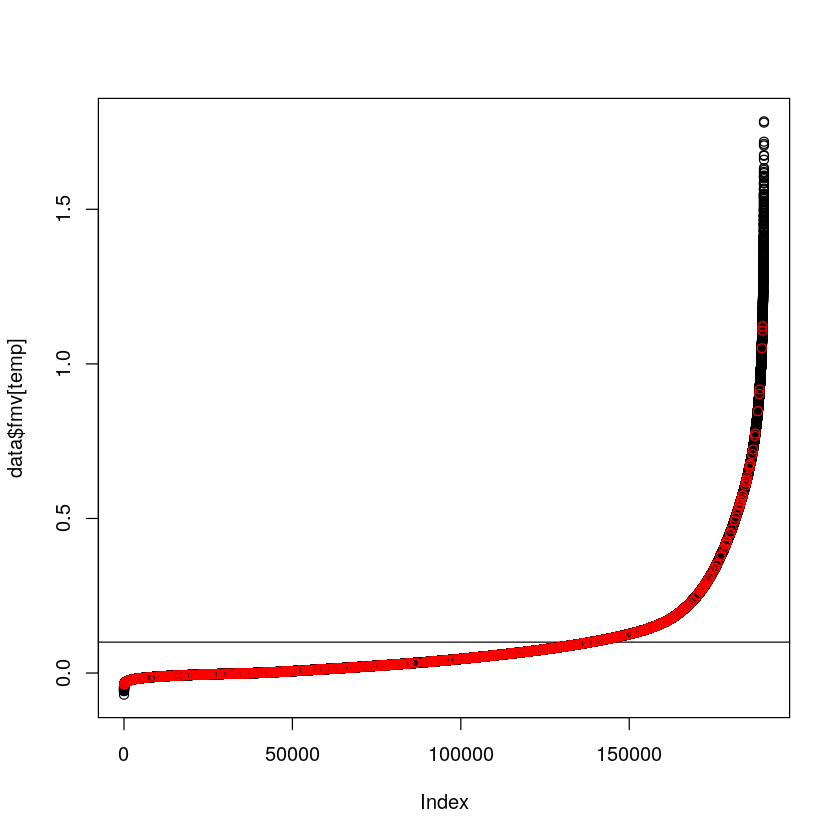

In [61]:
plot(data$fmv[temp])
abline(h=0.1)
points(representative_index$X2, data$fmv[temp][representative_index$X2], col="red")

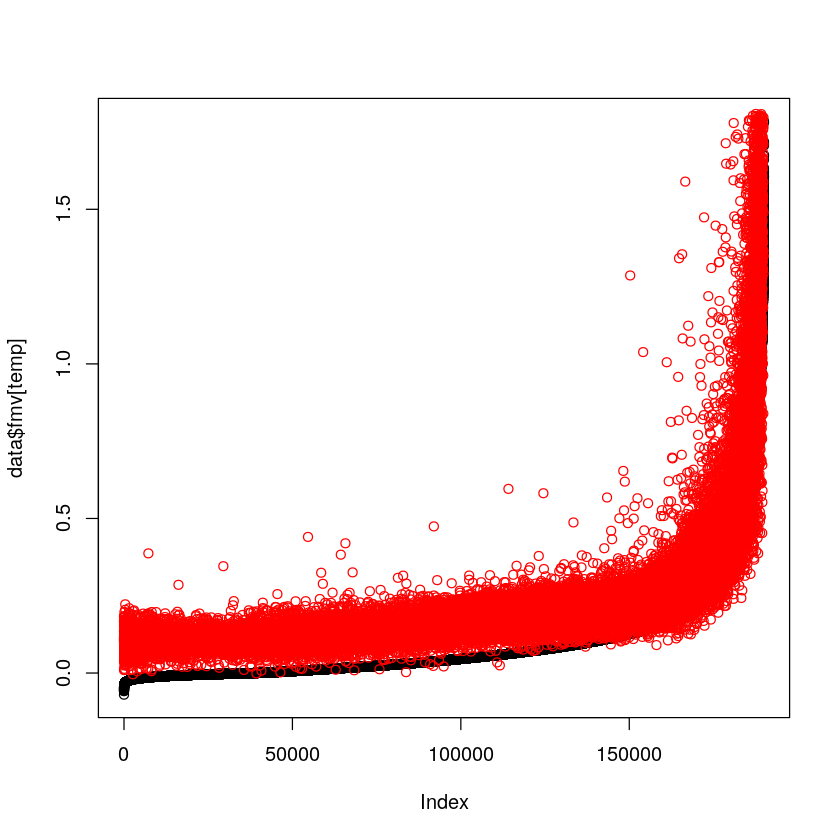

In [63]:
plot(data$fmv[temp]);
points(values[temp], col="red")

In [68]:
tail(data[temp,], n=10000)

,recordID,gbAmt,gmwbBalance,withdrawal,FundValue1,FundValue2,FundValue3,FundValue4,FundValue5,FundValue6,FundValue7,FundValue8,FundValue9,FundValue10,age,ttm,gender,productType,fmv
13570,13570,563804.1,0,0,37797.78,40094.59,23743.80,14089.65,28672.85,0.00,30256.81,23862.77,28237.87,28479.16,39.94521,5.421918,1,14,0.4533314
171857,171857,324830.7,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68049.18,89098.48,48.36164,11.090411,1,1,0.4533351
172569,172569,412870.1,0,0,0.00,0.00,228581.94,0.00,0.00,0.00,0.00,0.00,237673.91,0.00,41.35616,14.093151,1,1,0.4533461
151695,151695,462486.1,0,0,82380.72,78530.33,0.00,45543.80,0.00,80944.34,0.00,61629.07,65135.87,63307.40,35.52329,26.186301,1,11,0.4534633
172187,172187,460218.0,0,0,33309.72,30708.75,18822.01,17841.96,28854.83,32470.67,25251.81,25093.65,22087.89,0.00,64.45753,7.339726,1,1,0.4535013
10562,10562,577578.4,0,0,180625.18,0.00,0.00,0.00,0.00,174760.43,0.00,135287.50,0.00,0.00,46.61370,22.268493,1,14,0.4535182
18008,18008,547001.3,0,0,40963.72,38349.55,25133.51,17613.33,33749.46,40249.22,0.00,27698.03,0.00,31227.26,55.70411,9.339726,1,14,0.4535481
12049,12049,578400.3,0,0,35814.00,34894.48,20454.37,17864.57,30604.76,35707.21,27308.71,26047.08,24350.90,28067.83,40.44110,6.838356,0,14,0.4535764
159247,159247,438668.3,0,0,25905.74,23655.42,15729.36,11274.74,21434.64,25199.13,20376.41,17622.83,18050.35,19671.77,42.27945,9.424658,1,11,0.4535997
11676,11676,564617.0,0,0,60009.72,0.00,32206.02,0.00,55242.11,58112.41,0.00,0.00,38187.51,48463.90,54.70411,8.339726,0,14,0.4536101
